Epoch 1/50
  3/232 ━━━━━━━━━━━━━━━━━━━━ 9s 42ms/step - accuracy: 0.0643 - loss: 4.4400     

W0000 00:00:1715081959.945529     129 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


232/232 ━━━━━━━━━━━━━━━━━━━━ 15s 38ms/step - accuracy: 0.1511 - loss: 3.3670
Epoch 2/50
232/232 ━━━━━━━━━━━━━━━━━━━━ 10s 38ms/step - accuracy: 0.1625 - loss: 3.1866
Epoch 3/50
232/232 ━━━━━━━━━━━━━━━━━━━━ 10s 38ms/step - accuracy: 0.1623 - loss: 3.1582
Epoch 4/50
232/232 ━━━━━━━━━━━━━━━━━━━━ 10s 38ms/step - accuracy: 0.2320 - loss: 2.7705
Epoch 5/50
232/232 ━━━━━━━━━━━━━━━━━━━━ 10s 38ms/step - accuracy: 0.3090 - loss: 2.3293
Epoch 6/50
232/232 ━━━━━━━━━━━━━━━━━━━━ 10s 38ms/step - accuracy: 0.3161 - loss: 2.2541
Epoch 7/50
232/232 ━━━━━━━━━━━━━━━━━━━━ 10s 38ms/step - accuracy: 0.3193 - loss: 2.2193
Epoch 8/50
232/232 ━━━━━━━━━━━━━━━━━━━━ 10s 38ms/step - accuracy: 0.3213 - loss: 2.1983
Epoch 9/50
232/232 ━━━━━━━━━━━━━━━━━━━━ 10s 38ms/step - accuracy: 0.3219 - loss: 2.1882
Epoch 10/50
232/232 ━━━━━━━━━━━━━━━━━━━━ 10s 38ms/step - accuracy: 0.3233 - loss: 2.1789
Epoch 11/50
232/232 ━━━━━━━━━━━━━━━━━━━━ 10s 38ms/step - accuracy: 0.3236 - loss: 2.1734
Epoch 12/50
232/232 ━━━━━━━━━━━━━━━━━━━━ 

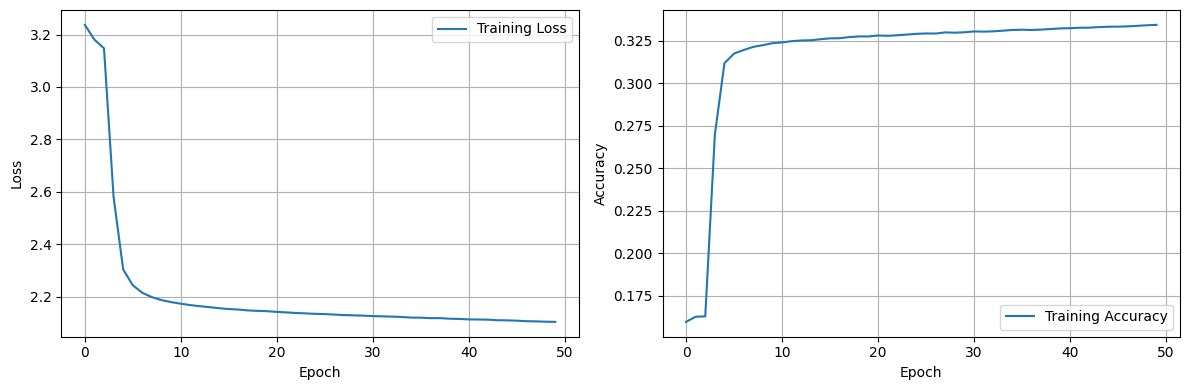

/opt/conda/lib/python3.10/site-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis 3 of a tensor of shape (1, 8, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


Hellssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssss

In [3]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Embedding, MultiHeadAttention
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import pandas as pd
import re
from pylab import rcParams
import numpy as np
import matplotlib.pyplot as plt


# Define the Transformer model
class Transformer(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, num_heads, num_layers, **kwargs):
        super(Transformer, self).__init__(**kwargs)
        self.embedding = Embedding(vocab_size, embedding_dim)
        self.transformer_blocks = [MultiHeadAttention(num_heads=num_heads, key_dim=embedding_dim) for _ in range(num_layers)]
        self.dense = Dense(vocab_size)

    def call(self, inputs):
        x = self.embedding(inputs)
        for transformer_block in self.transformer_blocks:
            x = transformer_block(x, x)
        x = self.dense(x)
        return x
    

# Hyperparameters
embedding_dim = 256
num_heads = 8
num_layers = 2
BATCH_SIZE = 64
EPOCHS = 50

# Dataset preparation
rcParams['figure.figsize'] = 20, 6
rcParams['axes.grid'] = True

df = [pd.read_json(f'../input/game-of-thrones-srt/season{i+1}.json') for i in range(7)]
df = pd.concat(df, axis=1)

df = pd.DataFrame(df.values.reshape(-1, 1), columns=['Script']).dropna().reset_index(drop=True)

cleanr = re.compile('<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});')

def cleanhtml(raw_html):
  cleantext = re.sub(cleanr, '', raw_html)
  return cleantext

df['Script'] = df['Script'].apply(cleanhtml)

text = '\n'.join(df['Script'].values)
vocab = sorted(set(text))

char2idx = {u:i for i, u in enumerate(vocab)}
idx2char = np.array(vocab)

text_as_int = np.array([char2idx[c] for c in text])

seq_length = 100
examples_per_epoch = len(text)//(seq_length+1)

char_dataset = tf.data.Dataset.from_tensor_slices(text_as_int)
sequences = char_dataset.batch(seq_length+1, drop_remainder=True)

def split_input_target(chunk):
    input_text = chunk[:-1]
    target_text = chunk[1:]
    return input_text, target_text

dataset = sequences.map(split_input_target)

BUFFER_SIZE = 10000
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)

# Loss function
def loss(labels, logits):
    return tf.keras.losses.sparse_categorical_crossentropy(labels, logits, from_logits=True)

# Build the model
model = Transformer(len(vocab), embedding_dim, num_heads, num_layers)
model.compile(loss=loss, optimizer=Adam(), metrics=['accuracy'])

# Train the model
history = model.fit(dataset, epochs=EPOCHS)

# Plot the training loss and accuracy
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')  # Use 'accuracy' here
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


# Generate text
def generate_text_transformer(model, start_string):
    # Convert the start string to numbers
    input_eval = [char2idx[s] for s in start_string]
    input_eval = tf.expand_dims(input_eval, 0)

    # Empty string to store the results
    text_generated = []

    # Here batch size == 1
    #model.reset_states()
    for i in range(1000):
        predictions = model(input_eval)
        predictions = tf.squeeze(predictions, 0)

        # Use a categorical distribution to predict the character returned by the model
        predicted_id = tf.random.categorical(predictions, num_samples=1)[-1,0].numpy()

        # Pass the predicted character as the next input to the model
        input_eval = tf.expand_dims([predicted_id], 0)

        text_generated.append(idx2char[predicted_id])

    return (start_string + ''.join(text_generated))

print(generate_text_transformer(model, start_string="Hells"))
